## Label Injnury Narratives Using Generative and Deep Learning Models
This project aims to compare the performances of **generative** and **deep learning models** on **document classification** using real-world and synthesized data. **The document classification task is to label a piece of injury narrative with the type of injury** to each narrative.

### Dataset
The dataset used is from a competition organized by NASA-Tournament Lab and National Institute for Occupational Safety & Health (NIOSH). The goal is to automate the processing of data in occupational safety and health (OSH) surveillance systems. Specifically, given a free text injury report, such as "*worker fell from the ladder after reaching out for a box.*” , the task is to **assign a injury code** from the Occupational Injuries and Illnesses Classification System (OIICS). The details of the task and competition can be found in a [blogpost](https://blogs.cdc.gov/niosh-science-blog/2020/02/26/ai-crowdsourcing/) by CDC (Center for Disease Control). The dataset is downloaded from [hugging face](https://huggingface.co/datasets/mayerantoine/injury-narrative-coding). The winning solutions can be found on [NASA Tournament Lab's Github Page](https://github.com/NASA-Tournament-Lab/CDC-NLP-Occ-Injury-Coding).

In [1]:
# import libraries
#!pip install -r requirements.txt
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel, get_linear_schedule_with_warmup

#### Load the dataset
The dataset used is stored on github in *csv* format. We first read the dataset as a *pandas dataframe*, and split them into **train, development, and test sets**.

In [2]:
# load dataset
url = "https://raw.githubusercontent.com/halfmoonliu/InjuryNoteLabel/main/Data/full_dataset.csv"
Dataset = pd.read_csv(url)

In [3]:
# Transfer event to event_ind
Unique_event_l = Dataset['event'].unique().tolist()
Unique_event_l = sorted(Unique_event_l)

# create event dictionary to map event to a number between 0-47 for NN model
ind_event_dict = dict()
event_ind_dict = dict()
for i in range(len(Unique_event_l)):
  ind_event_dict[i] = Unique_event_l[i]
  event_ind_dict[Unique_event_l[i]] = i

def mapEvent(eventRaw):
  return event_ind_dict[eventRaw]

Dataset['event_ind'] = Dataset['event'].apply(mapEvent)
Dataset.head()

,id,text,sex,age,event,event_ind
0,1,34YOM LIFTING BOXES AT WORK OVER USE OF HAND D...,1,34,71,41
1,2,A 28YOF BURNED ARM ON HOT GRILL AT WORK,2,28,53,26
2,3,A 67YOF WAS CLEANING AROUND CHAIRS IN SURGERY ...,2,67,55,28
3,4,24YF INJURED AT WORK REC INJURY WHEN TEST TUBE...,2,24,62,33
4,5,24YOF HAD A DRAWER FALL ON FINGER AT WORK ...,2,24,62,33


In [4]:
# split dataset into train, development, and test

train_set = Dataset.sample(frac=0.8, random_state=3275)

dev_set = Dataset.drop(train_set.index)
test_set = dev_set.sample(frac=0.5, random_state=3276)
dev_set = dev_set.drop(test_set.index)

train_set = train_set.reset_index(drop=True)
dev_set = dev_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape, dev_set.shape, test_set.shape)

(183856, 6) (22982, 6) (22982, 6)


### Tokenisation
The next step is to tokenize the documents, or individual injury report in this project. After tokenization, naratives become lists of words. We use the **BERT pretrained tokenizer**, provided by **Hugging face**. Below is an illustrating example.

In [5]:
#load pretrained tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# an illustrating example of input/ output of tokenizer
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens_sample = tokenizer.tokenize(sample_txt)
token_ids_sample = tokenizer.convert_tokens_to_ids(tokens_sample)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens_sample}')
print(f'Token IDs: {token_ids_sample}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


#### Tokenization with Attention Mask
With the _encode_plus_ method, we can obtain the tokens (mapped to indices) and attention masks of the input document.


In [7]:
# encoding of the illustrating example
encoding_sample_text = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  truncation=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding_sample_text

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

#### Determining max sequence length
Here, we use the bert tokenizer to tokezine all documents (i.e. injury narratives) in the dataset to determine the longest document length for model training.

In [8]:
token_lens = []

for txt in Dataset.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-9-e4e1bc198432>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


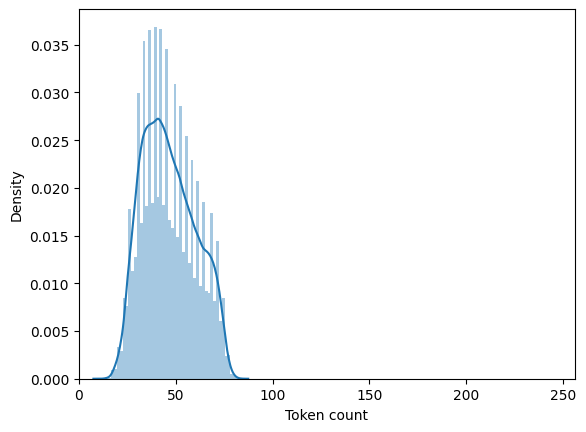

In [9]:
# draw a plot of the distribution of sequence length.
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

### Define a Dataset class for model training
With the information derived from exploring the dataset, we can start to define the document classification model. We start with **generating the input** for the document classification model. The _InjuryDataset_ class defined below specifies input (document, label, tokenizer and max_length) and output (_text_, _input_ids_, _attention_mask_, & _event_ in a dictionary) for the data loader.

In [10]:
# hyper parameters
MAX_LEN = 100
BATCH_SIZE = 16

In [11]:
class InjuryDataset(torch.utils.data.Dataset):
    def __init__(self, text, event_ind, tokenizer, max_len):
        self.text = text
        self.event_ind = event_ind
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        event_ind = self.event_ind[item]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
         )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'event_ind': torch.tensor(event_ind, dtype=torch.long)
        }


In [12]:
# use the InjuryDataset class to create a dataloader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = InjuryDataset(
    text=df.text.to_numpy(),
    event_ind=df.event_ind.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


The dataloaders defined below ouput put a batch of dataset (_text_, _input_ids_, _attention_mask_, _event_ind_) at a time. The batch size was defined previously.

In [13]:
# create data loader for train, dev and test dataset.
train_data_loader = create_data_loader(train_set, tokenizer, MAX_LEN, BATCH_SIZE)
dev_data_loader = create_data_loader(dev_set, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_set, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
# Get a batch
batch_example = next(iter(train_data_loader))

print("Batch size: {}".format(len(batch_example['text'])))
print("Content of the first element in the batch:")
print("text: {}".format(batch_example['text'][0]))
print("input_ids: {}".format(batch_example['input_ids'][0]))
print("attention_mask: {}".format(batch_example['attention_mask'][0]))
print("event_ind: {}".format(batch_example['event_ind'][0]))


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Batch size: 16
Content of the first element in the batch:
text: 47 YO FEMALE DROPPED PALLET ON FOOT AT WORK DX TOE INJURY  B
input_ids: tensor([  101,  3862,   162,  2346,   143, 15577, 12507,  2036, 22219, 17195,
         2101, 10069,  8544, 23955, 11943, 21748,   143,  2346, 14697, 13020,
          160,  9565,  2428,   141,  3190, 16972,  2036, 15969,  4538, 19556,
         3663,   139,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
# shape of the batch content
print(batch_example['input_ids'].shape)
print(batch_example['attention_mask'].shape)
print(batch_example['event_ind'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


#### Applying the bert model on a single batch of data


In [16]:
# create a model object
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

By applying the pretrained model to a single batch, we can examine the output of the model. Note that the **_number of hidden states_** of the pretrained model was **predefined by Hugging face**, the source where we downloaded the model parameters.

In [25]:

Model_output_batch_example = bert_model(
  input_ids=batch_example['input_ids'],
  attention_mask=batch_example['attention_mask']
)


last_hidden_state_batch_example = Model_output_batch_example['last_hidden_state']
pooled_output_batch_example =  Model_output_batch_example['pooler_output']

print("Output of the model applied to a single batch:")
print("Shape of last hidden state:")
print(last_hidden_state_batch_example.shape)
print("Shape of hidden states:")
print(bert_model.config.hidden_size)
print("Shape of pooler output:")
print(pooled_output_batch_example.shape)

Output of the model applied to a single batch:
Shape of last hidden state:
torch.Size([16, 100, 768])
Shape of hidden states:
768
Shape of pooler output:
torch.Size([16, 768])


### Define model object for document classification
After examining the output of the bert model when applying to a batch, we are ready to sketch out the model object for document classification. Specifically, we first **apply the pretrained model** on every batch of input, **apply dropout** for the output, and **pass the output to a fully connected layer**.

In [18]:
class EventClassifier(nn.Module):

  def __init__(self, n_classes):
    super(EventClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    model_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _ = model_output['last_hidden_state']
    pooled_output =  model_output['pooler_output']

    output = self.drop(pooled_output)
    return self.out(output)

In [19]:
# check the device that the model is trained on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
# model used to classify injury reports
EventClassModel = EventClassifier(len(train_set['event_ind'].unique().tolist()))
EventClassModel = EventClassModel.to(device)
EventClassModel

EventClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

#### An illustrating example of model prediction
The example below shows the output format. The output of the model of any given batch is of the shape _batchSize_ * _NumOfLabels_, which is the predicted probability of each label for each of the _batchSize_ texts in the batch. By outputing the ***most probable*** label, we obtain the predicted label of the document.

In [30]:
# Another Example = AE
AnotherExample = next(iter(train_data_loader))

# Load input_ids, attention mask and event_ind from dataloader
input_ids_AE = AnotherExample["input_ids"].to(device)
attention_mask_AE = AnotherExample["attention_mask"].to(device)
events_AE = AnotherExample["event_ind"].to(device)

# get output from model
outputs_AE = EventClassModel(
      input_ids=input_ids_AE,
      attention_mask=attention_mask_AE
    )
print("Model output shape for another batch of data:")
print(outputs_AE.shape)

print("Prediction got by outputing the event number with the highest probabliity:")
# get predictions
_, preds_AE = torch.max(outputs_AE, dim=1)
print(preds_AE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

Model output shape for another batch of data:
torch.Size([16, 48])
Prediction got by outputing the event number with the highest probabliity:
tensor([1.0737, 1.1782, 1.3566, 1.0783, 1.1573, 1.3008, 1.0691, 1.2367, 1.3177,
        1.0776, 0.8369, 0.8302, 1.0743, 0.7741, 0.8706, 1.0247],
       grad_fn=<MaxBackward0>)
tensor([34, 21, 21, 34,  2, 14,  2, 21, 14, 14, 22, 15, 19, 18, 17, 18])


## Define model (hyper)parameters
Below we determin the **training epochs**, **learning rate**, **optimizer**, and **loss function**. The scheduler method can _decrease_ the learning rate gradually during the training process.


In [22]:
EPOCHS = 10
learn_rate = 2e-5
optimizer = AdamW(EventClassModel.parameters(), lr=learn_rate, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
loss_fn = nn.CrossEntropyLoss().to(device)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0

  # load data from the dataloader
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    events = d["event_ind"].to(device)

    # get output from model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # get predictions
    _, preds = torch.max(outputs, dim=1)

    # calculate loss
    loss = loss_fn(outputs, events)

    # sum correct predictions
    correct_predictions += torch.sum(preds == events)

    # append loss
    losses.append(loss.item())

    # back propagation
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # optimization
    optimizer.step()

    # update learning rate (as defined in schedule)
    scheduler.step()

    # clear optimizer
    optimizer.zero_grad()

    # return accuracy and loss
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Training loop used on training data set
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    EventClassModel,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_set)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  # load data from the dataloader
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["event_ind"].to(device)

      # get predictions
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      # calculate losss
      loss = loss_fn(outputs, targets)

      # sum of  correct predictions
      correct_predictions += torch.sum(preds == targets)

      # append loss
      losses.append(loss.item())

  # return accuracy and loss
  return correct_predictions.double() / n_examples, np.mean(losses)
